### Data

In [1]:
# 导入包
import time
import os
from sklearn.model_selection import GridSearchCV
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, Compose, ToPILImage, ToTensor
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, mean_absolute_error, mean_squared_error, matthews_corrcoef
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from tqdm import tqdm
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
import torch.optim as optim

from PIL import Image
import PIL
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from collections import Counter
# for windows操作系统

from gtda.images import Binarizer,RadialFiltration,DensityFiltration, DilationFiltration, ErosionFiltration, SignedDistanceFiltration
from gtda.homology import CubicalPersistence
from gtda.diagrams import Scaler, HeatKernel, Amplitude
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.pipeline import make_pipeline, make_union
from gtda.diagrams import PersistenceEntropy
from gtda.images import HeightFiltration
from tqdm import tqdm
import torch
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB  
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error
import shap
import pywt
import pandas as pd
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceLandscape, BettiCurve, HeatKernel
from gtda.plotting import plot_diagram, plot_heatmap
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


In [2]:
#
def load_images(folder):
    X_list = []
    y_list = []
    label_mapping = {"benign": 0, "malignant": 1}
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)

            img = PIL.Image.open(img_path)
            img = img.resize((256, 256))
            img = torchvision.transforms.ToTensor()(img).squeeze()
            X_list.append(img)
            y_list.append(subfolder)
    return torch.stack(X_list), [label_mapping[label] for label in y_list]

In [3]:
X_all,y_all = load_images(r"./Dataset_BUSI_with_GT/Dataset_BUSI_with_GT/sample")
print('图像数量', len(X_all),Counter(y_all))
print('类别', set(y_all))

图像数量 665 Counter({0: 454, 1: 211})
类别 {0, 1}


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_all,y_all, test_size=0.2, random_state=36)

# 
print('训练集图像数量', len(X_train),X_train.shape, X_train.max(), X_train.min(),Counter(y_train))
print('类别', set(y_train))
print('测试集图像数量', len(X_test), X_test.shape ,X_test.max(), X_test.min(), Counter(y_test))
print('类别', set(y_test))

训练集图像数量 532 torch.Size([532, 256, 256]) tensor(1.) tensor(0.) Counter({0: 365, 1: 167})
类别 {0, 1}
测试集图像数量 133 torch.Size([133, 256, 256]) tensor(1.) tensor(0.) Counter({0: 89, 1: 44})
类别 {0, 1}


### TDA pipeline

In [5]:
# 管道 
# 初始图像保留
class Orige(BaseEstimator, TransformerMixin):
    def __init__(self, percentile):
        self.percentile = percentile
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        threshold = torch.kthvalue(X[X > 0],int(X[X > 0].numel() *self.percentile+1))[0]
        
        result_X = torch.where((X != 0) & (X < threshold), torch.tensor(0.0), X)
        min_val = torch.min(result_X[result_X > 0])
        max_val = torch.max(result_X)
        
        result_X[result_X > 0] = (result_X[result_X > 0] - min_val) / (max_val - min_val) * 300
        return result_X


# 小波管道
class Wavelet(BaseEstimator, TransformerMixin):
    def __init__(self,wavelet_type,direction):
        self.direction = direction
        self.wavelet_type = wavelet_type
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        LL, (LH, HL, HH) = pywt.dwt2(X, self.wavelet_type)
        result_X = F.interpolate(torch.tensor(eval(self.direction)).unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=True).squeeze(0)
        result_X[X == 0] = 0
        no_0 = X != 0
        result_X[no_0] = (result_X[no_0] - result_X[no_0].min()) / (result_X[no_0].max() - result_X[no_0].min())
        return result_X
    

# 比例二值化管道 越小点越多
class Binarizer_p(BaseEstimator, TransformerMixin):
    def __init__(self, percentile):
        self.percentile = percentile
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        threshold = torch.kthvalue(X[X > 0],int(X[X > 0].numel() *self.percentile+1))[0]
        return (X > threshold).float().numpy()

    
direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]

center_list = [
    [167, 55],
    [55, 167],
    [167, 167],
    [191, 167],
    [167, 191],
    [55, 55],
    [55, 191],
    [191, 55],
    [191, 191],
]

filtration_list = (
    [
        HeightFiltration(direction=np.array(direction), n_jobs=-1)
        for direction in direction_list
    ]
    + [RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
    + [DensityFiltration(),  
       DilationFiltration(), 
       ErosionFiltration(), 
       SignedDistanceFiltration()]
)

In [6]:
#
def get_pipeline(diagram_steps):

    for i in range(len(diagram_steps)):
        diagram_steps[i].extend([CubicalPersistence(n_jobs=-1), Scaler(n_jobs=-1)])    
            
    metric_list = [
        {"metric": "bottleneck", "metric_params": {}},
        {"metric": "wasserstein", "metric_params": {"p": 1}},
        {"metric": "wasserstein", "metric_params": {"p": 2}},
        {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
        {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
        {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
        {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
        {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
        {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
        {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
        {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
        {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
        {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
    ]

    feature_union = make_union(
        *[PersistenceEntropy(nan_fill_value=-1)]
        + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
    )

    tda_union = make_union(
        *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
        n_jobs=-1
    )
    return tda_union


def get_feature(tda_union,X_train,X_test,batch_size=256):
    train_feature = []
    test_feature = []
    for i in tqdm(range(0, len(X_train), batch_size)):
        train_feature.append(tda_union.fit_transform(X_train[i:i+batch_size]))
    train_feature = np.concatenate(train_feature)
    for i in tqdm(range(0, len(X_test), batch_size)):
        test_feature.append(tda_union.fit_transform(X_test[i:i+batch_size]))
    test_feature = np.concatenate(test_feature)

    return train_feature, test_feature

In [7]:
# 训练#

def train(method, train_feature, y_train, test_feature, y_test):
    start_time = time.time()
    np.random.seed(2703)
    torch.manual_seed(2703)
    train_X, train_Y = shuffle(train_feature, y_train)

    if method == 'random_forest':
        clf = RandomForestClassifier(random_state=27, n_estimators=200)
    elif method == 'svm':
        clf = SVC(kernel='linear', C=1.0, random_state=27)
    elif method == 'knn':
        clf = KNeighborsClassifier(n_neighbors=3)
    elif method == 'gbm':
        clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=27)
    elif method == 'naive_bayes':
        clf = GaussianNB()
    elif method == 'xgboost':
        clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    elif method == 'logistic_regression':
        clf = LogisticRegression(random_state=27)
    elif method == 'decision_tree':
        clf = DecisionTreeClassifier(random_state=27)
        
    scores = cross_val_score(clf, train_X, train_Y, cv=10)

    print(f"Cross-validation scores: {scores}")
    print(f"Mean CV score: {scores.mean()}")

    clf.fit(train_X, train_Y)

    # 预测测试集
    y_pred = clf.predict(test_feature)

    # 计算并打印 F1 分数、精确度和召回率
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"F1 score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"AUC: {auc}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MCC: {mcc}")

    end_time = time.time()
    return scores.mean(),accuracy, f1, precision, recall, auc, mae, mse, mcc, end_time - start_time


### Wavelets

In [8]:
def wavelet_feature(wavelet_name,X_train, X_test, batch_size):
    diagram_steps = [
        [   
            Wavelet(wavelet_type=wavelet_name,direction=x),
            Binarizer_p(percentile=0.4),
            filtration
        ]
        for x in ['LL', 'LH', 'HL', 'HH'] for filtration in filtration_list] 
    tda_union = get_pipeline(diagram_steps)

    train_feature, test_feature = get_feature(tda_union,X_train, X_test,batch_size)
    print('训练数据:',train_feature.shape,'测试数据:',test_feature.shape,'\n')
    return train_feature, test_feature


wavelet_feature_dict = {}
wavelet_names = ['haar', 'db1', 'db2', 'db3', 'sym2', 'sym3', 'coif1', 'coif2']

In [9]:
for wavelet_name in wavelet_names:
    print('小波:',wavelet_name,'提取特征中……')
    wavelet_feature_dict[wavelet_name+'_train'],wavelet_feature_dict[wavelet_name+'_test'] = wavelet_feature(wavelet_name,X_train, X_test,256)

小波: haar 提取特征中……


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:23<00:00, 203.17s/it]


训练数据: (532, 2352) 测试数据: (133, 2352) 

小波: db1 提取特征中……


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:24<00:00, 204.07s/it]


训练数据: (532, 2352) 测试数据: (133, 2352) 

小波: db2 提取特征中……


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:26<00:00, 206.53s/it]


训练数据: (532, 2352) 测试数据: (133, 2352) 

小波: db3 提取特征中……


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:28<00:00, 208.97s/it]


训练数据: (532, 2352) 测试数据: (133, 2352) 

小波: sym2 提取特征中……


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:29<00:00, 209.57s/it]


训练数据: (532, 2352) 测试数据: (133, 2352) 

小波: sym3 提取特征中……


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:28<00:00, 208.35s/it]


训练数据: (532, 2352) 测试数据: (133, 2352) 

小波: coif1 提取特征中……


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:28<00:00, 208.80s/it]


训练数据: (532, 2352) 测试数据: (133, 2352) 

小波: coif2 提取特征中……


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:31<00:00, 211.16s/it]

训练数据: (532, 2352) 测试数据: (133, 2352) 



In [10]:
# 特征提取 3_steps
# PFW_steps = [
#     [
#         Binarizer_p(percentile=0.4),
#         filtration
#     ]
#     for filtration in filtration_list] + [
#     [    
#         Wavelet(wavelet_type='coif2',direction=x),
#         Binarizer_p(percentile=0.4),
#         filtration
#     ] 
#     for x in ['LL', 'LH', 'HL', 'HH'] for filtration in filtration_list] + [
#     [    
#         Orige(percentile = x)
#     ]
#     for x in np.arange(0.1, 0.8, 0.1)
# ]


orige_steps = [
    [
        Binarizer(threshold=0.4),
        filtration
    ]
    for filtration in filtration_list]


pixel_steps = [
    [    
        Orige(percentile = x)
    ]
    for x in np.arange(0.1, 0.8, 0.1)
]
orige_p_steps = [
    [
        Binarizer_p(percentile=0.4),
        filtration
    ]
    for filtration in filtration_list]

In [12]:
for step in ['orige', 'pixel','orige_p']:
    print(step,'提取特征中……')
    
    tda_union = get_pipeline(eval(step+'_steps'))
    wavelet_feature_dict[step+'_train'],wavelet_feature_dict[step+'_test'] = get_feature(tda_union,X_train, X_test,batch_size=256)

orige_p 提取特征中……


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:56<00:00, 56.95s/it]


In [18]:
wavelet_feature_dict['8W2O_train'] = np.concatenate(([wavelet_feature_dict[x+ '_train'] for x in wavelet_names+['orige_p', 'pixel']]),axis=1)
wavelet_feature_dict['8W2O_test'] = np.concatenate(([wavelet_feature_dict[x+ '_test'] for x in wavelet_names+['orige_p','pixel']]),axis=1)

### Machine learning

In [20]:
#
ML_train_dict = {}
methods = ['random_forest', 'svm', 'knn', 'gbm', 'naive_bayes','xgboost','decision_tree','logistic_regression']
for method in methods:
    for wavelet_name in wavelet_names+['orige', 'pixel','orige_p','8W2O']:
        print(f"训练方法: {method},小波名称：{wavelet_name}")
        mean_cv_score,test_score, f1, precision, recall, auc, mae, mse, mcc,time_ = train(method, wavelet_feature_dict[wavelet_name+'_train'], y_train, wavelet_feature_dict[wavelet_name+'_test'], y_test)
        print(f"Mean CV score: {mean_cv_score}, Test score: {test_score}")
        ML_train_dict[f'{wavelet_name}_{method}_Mean CV score'] = mean_cv_score
        ML_train_dict[f'{wavelet_name}_{method}_Test score'] = test_score
        ML_train_dict[f'{wavelet_name}_{method}_f1'] = f1
        ML_train_dict[f'{wavelet_name}_{method}_precision'] = precision
        ML_train_dict[f'{wavelet_name}_{method}_recall'] = recall
        ML_train_dict[f'{wavelet_name}_{method}_auc'] = auc
        ML_train_dict[f'{wavelet_name}_{method}_mae'] = mae
        ML_train_dict[f'{wavelet_name}_{method}_mse'] = mse
        ML_train_dict[f'{wavelet_name}_{method}_mcc'] = mcc
        ML_train_dict[f'{wavelet_name}_{method}_time'] = time_

训练方法: random_forest,小波名称：haar
Cross-validation scores: [0.92592593 0.88888889 0.86792453 0.90566038 0.90566038 0.9245283
 0.88679245 0.88679245 0.8490566  0.86792453]
Mean CV score: 0.8909154437456325
Accuracy: 0.8571428571428571
F1 score: 0.8462673476757984
Precision: 0.8741140061894779
Recall: 0.8571428571428571
AUC: 0.7898365679264555
MAE: 0.14285714285714285
MSE: 0.14285714285714285
MCC: 0.678062459988562
Mean CV score: 0.8909154437456325, Test score: 0.8571428571428571
训练方法: random_forest,小波名称：db1
Cross-validation scores: [0.92592593 0.88888889 0.86792453 0.90566038 0.90566038 0.9245283
 0.88679245 0.88679245 0.8490566  0.86792453]
Mean CV score: 0.8909154437456325
Accuracy: 0.8571428571428571
F1 score: 0.8462673476757984
Precision: 0.8741140061894779
Recall: 0.8571428571428571
AUC: 0.7898365679264555
MAE: 0.14285714285714285
MSE: 0.14285714285714285
MCC: 0.678062459988562
Mean CV score: 0.8909154437456325, Test score: 0.8571428571428571
训练方法: random_forest,小波名称：db2
Cross-validati

Accuracy: 0.7443609022556391
F1 score: 0.6843812886513979
Precision: 0.8150253682987958
Recall: 0.7443609022556391
AUC: 0.6136363636363636
MAE: 0.2556390977443609
MSE: 0.2556390977443609
MCC: 0.40552357732497496
Mean CV score: 0.9042278127183787, Test score: 0.7443609022556391
训练方法: svm,小波名称：coif1
Cross-validation scores: [0.85185185 0.90740741 0.90566038 0.88679245 0.86792453 0.96226415
 0.8490566  0.90566038 0.88679245 0.88679245]
Mean CV score: 0.8910202655485675
Accuracy: 0.3383458646616541
F1 score: 0.18028404344193819
Precision: 0.7794486215538847
Recall: 0.3383458646616541
AUC: 0.5056179775280899
MAE: 0.6616541353383458
MSE: 0.6616541353383458
MCC: 0.06119900613621045
Mean CV score: 0.8910202655485675, Test score: 0.3383458646616541
训练方法: svm,小波名称：coif2
Cross-validation scores: [0.87037037 0.81481481 0.86792453 0.8490566  0.9245283  0.9245283
 0.75471698 0.9245283  0.88679245 0.8490566 ]
Mean CV score: 0.8666317260656884
Accuracy: 0.6691729323308271
F1 score: 0.5365440628598523


Cross-validation scores: [0.83333333 0.87037037 0.86792453 0.86792453 0.88679245 0.90566038
 0.73584906 0.86792453 0.81132075 0.81132075]
Mean CV score: 0.8458420684835779
Accuracy: 0.7669172932330827
F1 score: 0.7630809197594025
Precision: 0.7615848130965712
Recall: 0.7669172932330827
AUC: 0.7224208375893768
MAE: 0.23308270676691728
MSE: 0.23308270676691728
MCC: 0.45975935917319954
Mean CV score: 0.8458420684835779, Test score: 0.7669172932330827
训练方法: gbm,小波名称：haar
Cross-validation scores: [0.90740741 0.85185185 0.90566038 0.96226415 0.96226415 0.90566038
 0.86792453 0.88679245 0.86792453 0.88679245]
Mean CV score: 0.9004542278127184
Accuracy: 0.7969924812030075
F1 score: 0.8027086349413907
Precision: 0.8342149773340455
Recall: 0.7969924812030075
AUC: 0.8195863125638406
MAE: 0.20300751879699247
MSE: 0.20300751879699247
MCC: 0.6035431737956941
Mean CV score: 0.9004542278127184, Test score: 0.7969924812030075
训练方法: gbm,小波名称：db1
Cross-validation scores: [0.90740741 0.85185185 0.90566038

Cross-validation scores: [0.72222222 0.7962963  0.73584906 0.79245283 0.83018868 0.8490566
 0.71698113 0.73584906 0.69811321 0.69811321]
Mean CV score: 0.7575122292103424
Accuracy: 0.8045112781954887
F1 score: 0.8091747440891385
Precision: 0.8269211991016502
Recall: 0.8045112781954887
AUC: 0.8137129724208376
MAE: 0.19548872180451127
MSE: 0.19548872180451127
MCC: 0.5979218700853348
Mean CV score: 0.7575122292103424, Test score: 0.8045112781954887
训练方法: naive_bayes,小波名称：coif1
Cross-validation scores: [0.7962963  0.75925926 0.73584906 0.77358491 0.79245283 0.79245283
 0.71698113 0.77358491 0.73584906 0.62264151]
Mean CV score: 0.749895178197065
Accuracy: 0.7894736842105263
F1 score: 0.7925206385582957
Precision: 0.7988332276474319
Recall: 0.7894736842105263
AUC: 0.7794943820224719
MAE: 0.21052631578947367
MSE: 0.21052631578947367
MCC: 0.5430006777369091
Mean CV score: 0.749895178197065, Test score: 0.7894736842105263
训练方法: naive_bayes,小波名称：coif2
Cross-validation scores: [0.77777778 0.8148

Cross-validation scores: [0.88888889 0.88888889 0.9245283  0.96226415 0.94339623 0.96226415
 0.90566038 0.9245283  0.90566038 0.86792453]
Mean CV score: 0.9174004192872116
Accuracy: 0.8947368421052632
F1 score: 0.8947368421052632
Precision: 0.8947368421052632
Recall: 0.8947368421052632
AUC: 0.8811287027579163
MAE: 0.10526315789473684
MSE: 0.10526315789473684
MCC: 0.7622574055158324
Mean CV score: 0.9174004192872116, Test score: 0.8947368421052632
训练方法: decision_tree,小波名称：haar
Cross-validation scores: [0.77777778 0.7962963  0.88679245 0.9245283  0.83018868 0.88679245
 0.75471698 0.8490566  0.79245283 0.81132075]
Mean CV score: 0.8309923130677849
Accuracy: 0.6015037593984962
F1 score: 0.6113904208299861
Precision: 0.6878247342494166
Recall: 0.6015037593984962
AUC: 0.6390449438202246
MAE: 0.39849624060150374
MSE: 0.39849624060150374
MCC: 0.263852922998431
Mean CV score: 0.8309923130677849, Test score: 0.6015037593984962
训练方法: decision_tree,小波名称：db1
Cross-validation scores: [0.77777778 0.7

Cross-validation scores: [0.85185185 0.88888889 0.90566038 0.8490566  0.94339623 0.96226415
 0.86792453 0.86792453 0.8490566  0.8490566 ]
Mean CV score: 0.8835080363382251
Accuracy: 0.6842105263157895
F1 score: 0.5701893072602455
Precision: 0.7854560064282845
Recall: 0.6842105263157895
AUC: 0.5227272727272727
MAE: 0.3157894736842105
MSE: 0.3157894736842105
MCC: 0.17573085218040105
Mean CV score: 0.8835080363382251, Test score: 0.6842105263157895
训练方法: logistic_regression,小波名称：coif1
Cross-validation scores: [0.87037037 0.90740741 0.9245283  0.96226415 0.98113208 0.96226415
 0.90566038 0.86792453 0.86792453 0.88679245]
Mean CV score: 0.9136268343815515
Accuracy: 0.6992481203007519
F1 score: 0.6015267526614702
Precision: 0.7925045171067202
Recall: 0.6992481203007519
AUC: 0.5454545454545454
MAE: 0.3007518796992481
MSE: 0.3007518796992481
MCC: 0.25044006370970917
Mean CV score: 0.9136268343815515, Test score: 0.6992481203007519
训练方法: logistic_regression,小波名称：coif2
Cross-validation scores: [

In [115]:
# # 
# wavelet_name = 'orige_p'
# wavelet_feature_dict[wavelet_name+'_train'], y_train, wavelet_feature_dict[wavelet_name+'_test'], y_test
# # 创建一个随机森林分类器
# clf = RandomForestClassifier(random_state=27)

# # 定义超参数和它们的取值范围
# param_grid = {
#     'n_estimators': [100, 200, 300],  # 可以增加更多的值
#     'max_depth': [None, 10, 20, 30],  # 控制树的最大深度
#     'min_samples_split': [2, 5, 10],  # 最小拆分样本数
#     'min_samples_leaf': [1, 2, 4],  # 最小叶子样本数
#     'max_features': ['auto', 'sqrt', 'log2']  # 控制特征的最大数量
# }

# # 使用网格搜索进行超参数调优
# grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1)
# grid_search.fit(wavelet_feature_dict[wavelet_name+'_train'], y_train)

# # 输出最优的超参数组合
# best_params = grid_search.best_params_
# print("最优的超参数组合：", best_params)

# # 创建使用最优超参数的随机森林模型
# best_clf = RandomForestClassifier(random_state=27, **best_params)

# # 训练最优模型
# best_clf.fit(wavelet_feature_dict[wavelet_name+'_train'], y_train)

# # 在测试集上评估最优模型
# y_pred = best_clf.predict(wavelet_feature_dict[wavelet_name+'_test'])
# accuracy = accuracy_score(y_test, y_pred)
# print("在测试集上的准确率：", accuracy)


最优的超参数组合： {'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
在测试集上的准确率： 0.782


In [72]:
import pickle

# 将字典保存到文件中
with open('wavelet_feature_dict.pickle', 'wb') as f:
    pickle.dump(wavelet_feature_dict, f)

# 保存字典到文件
with open('ML_train_dict.pickle', 'wb') as file:
    pickle.dump(ML_train_dict, file)

### Wavelet-ML

In [5]:
# 导入数据
import pickle

# 保存字典到文件

# 从文件中读取字典
with open('wavelet_feature_dict.pickle', 'rb') as file:
    wavelet_feature_dict = pickle.load(file)
with open('ML_train_dict.pickle', 'rb') as file:
    ML_train_dict = pickle.load(file)

wavelet_names = ['haar', 'db1', 'db2', 'db3', 'sym2', 'sym3', 'coif1', 'coif2']
methods = ['random_forest', 'svm', 'knn', 'gbm', 'naive_bayes','xgboost','decision_tree','logistic_regression']
metrics = ['Mean CV score','Test score','f1','precision','recall','auc','mae','mse','time']

In [6]:
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]


## one example

In [20]:
df = pd.DataFrame(columns=metrics, index=[f'{wavelet_name} + {method}' for wavelet_name in ['pixel', 'orige_p'] for method in methods])
for wavelet_name in ['pixel', 'orige_p']:
    for method in methods:
        for metric in metrics:
            df.at[f'{wavelet_name} + {method}', metric] = round(ML_train_dict[f'{wavelet_name}_{method}_{metric}'], 3)
df.style.format("{:.3f}").apply(highlight_max, axis=0)

In [21]:
df = pd.DataFrame(columns=metrics, index=[f'{wavelet_name} + {method}' for wavelet_name in ['pixel', 'orige_p','8W2O','8W2Os'] for method in ['xgboost']])
for wavelet_name in  ['pixel', 'orige_p','8W2O','8W2Os']:
    for method in ['xgboost']:
        for metric in metrics:
            df.at[f'{wavelet_name} + {method}', metric] = round(ML_train_dict[f'{wavelet_name}_{method}_{metric}'], 3)
df.style.format("{:.3f}").apply(highlight_max, axis=0)

In [ ]:
df = pd.DataFrame(columns=metrics, index=[f'{wavelet_name} + {method}' for wavelet_name in ['pixel', 'orige_p'] for method in methods])
for wavelet_name in ['pixel', 'orige_p']:
    for method in methods:
        for metric in metrics:
            df.at[f'{wavelet_name} + {method}', metric] = round(ML_train_dict[f'{wavelet_name}_{method}_{metric}'], 3)
df.style.format("{:.3f}").apply(highlight_max, axis=0)



df = pd.DataFrame(columns=metrics, index=[f'{wavelet_name} + {method}' for wavelet_name in ['pixel', 'orige_p','8W2O','8W2Os'] for method in ['xgboost']])
for wavelet_name in  ['pixel', 'orige_p','8W2O','8W2Os']:
    for method in ['xgboost']:
        for metric in metrics:
            df.at[f'{wavelet_name} + {method}', metric] = round(ML_train_dict[f'{wavelet_name}_{method}_{metric}'], 3)
df.style.format("{:.3f}").apply(highlight_max, axis=0)

In [7]:
# 测试集ACC
df = pd.DataFrame(index=(['orige_p','orige', 'pixel','8W2O']+wavelet_names), columns=methods)
for wavelet_name in ['orige_p','orige', 'pixel','8W2O']+wavelet_names:
    for method in methods:
        mean_cv_score = ML_train_dict.get(f'{wavelet_name}_{method}_Mean CV score', None)
        test_score = ML_train_dict.get(f'{wavelet_name}_{method}_Test score', None)
        df.loc[wavelet_name, method] = f" {test_score:.3f}"

df.style.apply(highlight_max, axis=1)

In [8]:
# 交叉验证ACC
df = pd.DataFrame(index=(['orige_p','orige', 'pixel','8W2O']+wavelet_names), columns=methods)
for wavelet_name in ['orige_p','orige', 'pixel','8W2O']+wavelet_names:
    for method in methods:
        mean_cv_score = ML_train_dict.get(f'{wavelet_name}_{method}_Mean CV score', None)
        test_score = ML_train_dict.get(f'{wavelet_name}_{method}_Test score', None)
        df.loc[wavelet_name, method] = f" {mean_cv_score:.3f}"

df.style.apply(highlight_max, axis=1)

In [9]:
# AUC
df = pd.DataFrame(index=(['orige_p','orige', 'pixel','8W2O']+wavelet_names), columns=methods)
for wavelet_name in ['orige_p','orige', 'pixel','8W2O']+wavelet_names:
    for method in methods:
        mean_cv_score = ML_train_dict.get(f'{wavelet_name}_{method}_Mean CV score', None)
        test_score = ML_train_dict.get(f'{wavelet_name}_{method}_Test score', None)
        auc =  ML_train_dict.get(f'{wavelet_name}_{method}_auc', None)
        df.loc[wavelet_name, method] = f" {auc:.3f}"

df.style.apply(highlight_max, axis=1)

### SHAP Analysis

In [46]:
# 训练#

def train(method, train_feature, y_train, test_feature, y_test):
    start_time = time.time()
    np.random.seed(2703)
    torch.manual_seed(2703)
    train_X, train_Y = shuffle(train_feature, y_train)

    if method == 'random_forest':
        clf = RandomForestClassifier(random_state=27, n_estimators=200)
    elif method == 'svm':
        clf = SVC(kernel='linear', C=1.0, random_state=27)
    elif method == 'knn':
        clf = KNeighborsClassifier(n_neighbors=3)
    elif method == 'gbm':
        clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=27)
    elif method == 'naive_bayes':
        clf = GaussianNB()
    elif method == 'xgboost':
        clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    elif method == 'logistic_regression':
        clf = LogisticRegression(random_state=27)
    elif method == 'decision_tree':
        clf = DecisionTreeClassifier(random_state=27)
        
    scores = cross_val_score(clf, train_X, train_Y, cv=10)

    clf.fit(train_X, train_Y)

    y_pred = clf.predict(test_feature)

    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    end_time = time.time()
    return scores.mean(),accuracy, f1, precision, recall, auc, mae, mse, mcc, end_time - start_time, clf


In [47]:
method = 'xgboost'
wavelet_name = '8W2O'
print(f"训练方法: {method},小波名称：{wavelet_name}")
mean_cv_score,test_score, f1, precision, recall, auc, mae, mse, mcc,time_, clf10 = train(method, wavelet_feature_dict[wavelet_name+'_train'], y_train, wavelet_feature_dict[wavelet_name+'_test'], y_test)
print(f"Mean CV score: {mean_cv_score}, Test score: {test_score}")
print(f'{wavelet_name}_{method}_time,{time_:.5f}秒')

训练方法: xgboost,小波名称：8W2O
Mean CV score: 0.9174004192872116, Test score: 0.8947368421052632
8W2O_xgboost_time,29.29721秒


In [49]:
test_feature = wavelet_feature_dict['8W2O_test']
explainer = shap.TreeExplainer(clf10)
shap_values = explainer.shap_values(test_feature)[1]
feature_contributions = np.abs(shap_values)

In [43]:
# 特征命名
filtration_list=[
 'Height[1, 0]',
 'Height[1, 1]',
 'Height[0, 1]',
 'Height[-1,  1]',
 'Height[-1,  0]',
 'Height[-1, -1]',
 'Height[ 0, -1]',
 'Height[ 1, -1]',
 'Radial[167,  55]',
 'Radial[ 55, 167]',
 'Radial[167, 167]',
 'Radial[191, 167]',
 'Radial[167, 191]',
 'Radial[55, 55]',
 'Radial[ 55, 191]',
 'Radial[191,  55]',
 'Radial[191, 191]',
 'Density',
 'Dilation',
 'Erosion',
 'SignedDistance']
metric_list = [
    {"metric": "PersistenceEntropy", "metric_params": {}},
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]
# 构建特征名称列表
feature_names = []
n=1
for w in wavelet_names:
    for x in ['LL', 'LH', 'HL', 'HH'] :
        for filtration in filtration_list:
            for metric in metric_list:
                feature_name_1 = f"{n:<6}{w:<5}_{x}_{filtration:<17} local  {str(metric['metric']):>19}{str(metric['metric_params']):>38}"
                n=n+1
                feature_name_2 = f"{n:<6}{w:<5}_{x}_{filtration:<17} global {str(metric['metric']):>19}{str(metric['metric_params']):>38}"
                n=n+1
                feature_names.extend([feature_name_1, feature_name_2])
for filtration in filtration_list:
    for metric in metric_list:
        feature_name_1 = f"{n:<6}     {filtration:<17}     local  {str(metric['metric']):>19}{str(metric['metric_params']):>38}"
        n=n+1
        feature_name_2 = f"{n:<6}     {filtration:<17}     global {str(metric['metric']):>19}{str(metric['metric_params']):>38}"
        n=n+1
        feature_names.extend([feature_name_1, feature_name_2])


for x in np.arange(0.1, 0.8, 0.1):
    for metric in metric_list:
        feature_name_1 = f"{n:<6}      percentile={x:.1f}       local  {str(metric['metric']):>19}{str(metric['metric_params']):>38}"
        n=n+1
        feature_name_2 = f"{n:<6}      percentile={x:.1f}       global {str(metric['metric']):>19}{str(metric['metric_params']):>38}"
        n=n+1
        feature_names.extend([feature_name_1, feature_name_2])
len(feature_names)

19600

In [50]:
#
threshold = 0

selected_feature_indices = np.where(feature_contributions > threshold)[0]

important_feature_names = [feature_names[i] for i in selected_feature_indices]
print(len(important_feature_names))

selected_features = test_feature[:, selected_feature_indices]

240


In [52]:
train_feature = wavelet_feature_dict['8W2O_train']
selected_train = train_feature[:, selected_feature_indices]
selected_test = test_feature[:, selected_feature_indices]

print(selected_train.shape)
print(selected_test.shape)

(532, 240)
(133, 240)


In [57]:
# lst = []


for x in range(147,148):
    selected_feature_indices = np.argpartition(feature_contributions, -x)[-x:]
    print(x,len(selected_feature_indices))

# for x in range(1,10):
#     threshold = 0+0.001*x
#     selected_feature_indices = np.where(feature_contributions > threshold)[0]
#     print(threshold,len(selected_feature_indices))
    
    selected_features = test_feature[:, selected_feature_indices]
    train_feature = wavelet_feature_dict['8W2O_train']
    selected_train = train_feature[:, selected_feature_indices]
    selected_test = test_feature[:, selected_feature_indices]
    mean_cv_score,test_score, f1, precision, recall, auc, mae, mse, mcc,time_, clf10 = train(method, selected_train, y_train,selected_test, y_test)
    print('%.3f' % test_score, '%.3f' % mean_cv_score)
    lst.append((len(selected_feature_indices),test_score, mean_cv_score))

147 147
0.932 0.936



Mean CV score: 0.936 

test_score：0.932 

In [60]:
wavelet_feature_dict['8W2Os_train'] = selected_train
wavelet_feature_dict['8W2Os_test'] = selected_test

In [62]:
# 
method = 'xgboost'
wavelet_name = '8W2Os'
print(f"训练方法: {method},小波名称：{wavelet_name}")
mean_cv_score,test_score, f1, precision, recall, auc, mae, mse, mcc,time_, clf10 = train(method, wavelet_feature_dict[wavelet_name+'_train'], y_train, wavelet_feature_dict[wavelet_name+'_test'], y_test)
print(f"Mean CV score: {mean_cv_score}, Test score: {test_score}")
ML_train_dict[f'{wavelet_name}_{method}_Mean CV score'] = mean_cv_score
ML_train_dict[f'{wavelet_name}_{method}_Test score'] = test_score
ML_train_dict[f'{wavelet_name}_{method}_f1'] = f1
ML_train_dict[f'{wavelet_name}_{method}_precision'] = precision
ML_train_dict[f'{wavelet_name}_{method}_recall'] = recall
ML_train_dict[f'{wavelet_name}_{method}_auc'] = auc
ML_train_dict[f'{wavelet_name}_{method}_mae'] = mae
ML_train_dict[f'{wavelet_name}_{method}_mse'] = mse
ML_train_dict[f'{wavelet_name}_{method}_mcc'] = mcc
ML_train_dict[f'{wavelet_name}_{method}_time'] = time_

训练方法: xgboost,小波名称：8W2Os
Mean CV score: 0.936198462613557, Test score: 0.9323308270676691


In [27]:
from gtda.plotting import plot_point_cloud, plot_heatmap

In [28]:
# shap
test_feature = wavelet_feature_dict['8W2O_test']
# SHAP解释器
explainer = shap.TreeExplainer(clf10)
# 计算测试集的SHAP值
shap_values = explainer.shap_values(test_feature)
# 绘制SHAP汇总图

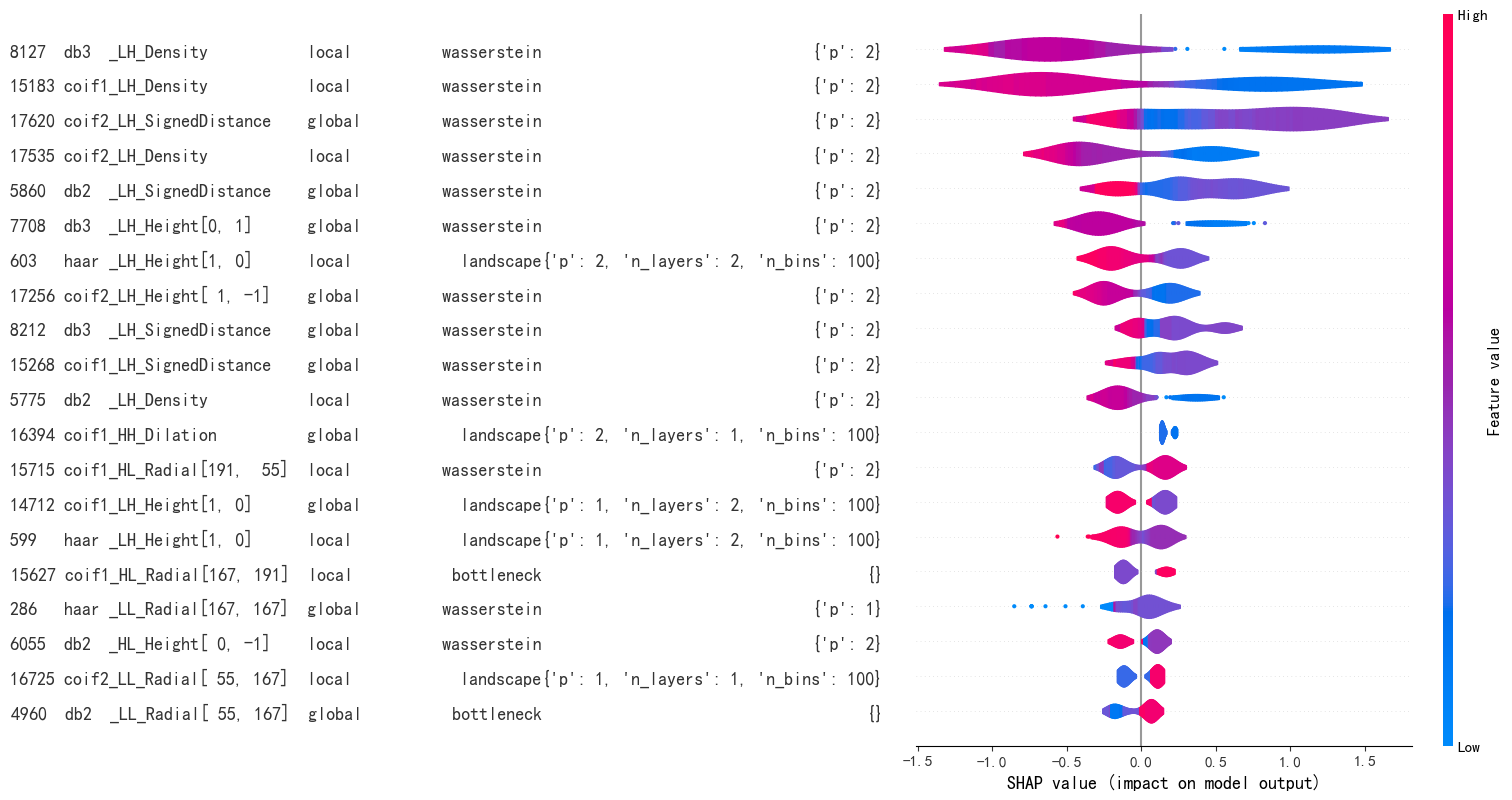

In [29]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib as mpl
rcParams['font.serif'] = ['Times New Roman']

shap.summary_plot(shap_values, test_feature, feature_names=feature_names,max_display=20,plot_type="violin")

### ROC

In [58]:
metrics = ['Mean CV score','Test score','f1','precision','recall','auc','mae','mse','mcc','time']

In [63]:
df = pd.DataFrame(columns=metrics, index=[f'{wavelet_name} + {method}' for wavelet_name in ['pixel', 'orige_p','haar','8W2O','8W2Os'] for method in ['xgboost']])
for wavelet_name in  ['pixel', 'orige_p','haar','8W2O','8W2Os']:
    for method in ['xgboost']:
        for metric in metrics:
            df.at[f'{wavelet_name} + {method}', metric] = round(ML_train_dict[f'{wavelet_name}_{method}_{metric}'], 3)
df.style.format("{:.3f}").apply(highlight_max, axis=0)

In [64]:
def ROC(y_test,y_scores):
    fpr, tpr, thresholds = roc_curve(y_test,y_scores[:,1])

    # 使用matplotlib绘制ROC曲线
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [65]:
# 训练函数
def train(method, train_feature, y_train, test_feature, y_test):
    start_time = time.time()
    np.random.seed(2703)
    torch.manual_seed(2703)
    train_X, train_Y = shuffle(train_feature, y_train)

    if method == 'random_forest':
        # 创建随机森林分类器，指定随机种子和决策树数量
        clf = RandomForestClassifier(random_state=27, n_estimators=200)
    elif method == 'svm':
        # 创建支持向量机分类器
        clf = SVC(kernel='linear', C=1.0, probability=True, random_state=27)
    elif method == 'knn':
        # 创建K-最近邻分类器
        clf = KNeighborsClassifier(n_neighbors=3)  # 可以根据需要调整邻居数量
    elif method == 'gbm':
        # 创建梯度提升树分类器
        clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=27)
    elif method == 'naive_bayes':
        # 创建朴素贝叶斯分类器（这里使用高斯朴素贝叶斯）
        clf = GaussianNB()
    elif method == 'xgboost':
        clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    elif method == 'logistic_regression':
        clf = LogisticRegression(random_state=27)
    elif method == 'decision_tree':
        clf = DecisionTreeClassifier(random_state=27)
    # 可以添加其他分类器的选项

    # 进行交叉验证
    scores = cross_val_score(clf, train_X, train_Y, cv=10)

    print(f"Mean CV score: {scores.mean()}")
    clf.fit(train_X, train_Y)
    
    
    end_time = time.time()
    print(f"train time: {end_time - start_time}")
    
    test_score = clf.score(test_feature, y_test)
    print(f"Test set score: {test_score}")

    predictions = clf.predict_proba(test_feature)
    return predictions

In [67]:
pre= {}
method = 'xgboost'
steps = ['pixel', 'orige_p','haar','8W2O','8W2Os']
for step in steps:
    print(f"训练方法: {method},特征：{step}")
    predictions = train(method, wavelet_feature_dict[step+'_train'], y_train, wavelet_feature_dict[step+'_test'], y_test)
    pre[f'{step}_{method}_pre'] = predictions

训练方法: xgboost,特征：pixel
Mean CV score: 0.7876659678546472
train time: 0.894005537033081
Test set score: 0.7819548872180451
训练方法: xgboost,特征：orige_p
Mean CV score: 0.7914395527603075
train time: 1.5720112323760986
Test set score: 0.7894736842105263
训练方法: xgboost,特征：haar
Mean CV score: 0.8986023759608666
train time: 3.972028970718384
Test set score: 0.9022556390977443
训练方法: xgboost,特征：8W2O
Mean CV score: 0.9174004192872116
train time: 29.43221116065979
Test set score: 0.8947368421052632
训练方法: xgboost,特征：8W2Os
Mean CV score: 0.936198462613557
train time: 0.49900364875793457
Test set score: 0.9323308270676691


In [35]:
# 
method = 'svm'
step = 'orige_p'
train_feature, test_feature = wavelet_feature_dict[step+'_train'], wavelet_feature_dict[step+'_test']
clf = SVC(kernel='linear', C=1.0, probability=True, random_state=27)
start_time = time.time()
np.random.seed(2703)
torch.manual_seed(2703)
train_X, train_Y = shuffle(train_feature, y_train)
scores = cross_val_score(clf, train_X, train_Y, cv=10)
print(f"Mean CV score: {scores.mean()}")
clf.fit(train_X, train_Y)
end_time = time.time()
print(f"train time: {end_time - start_time}")
test_score = clf.score(test_feature, y_test)
print(f"Test set score: {test_score}")
predictions = clf.predict_proba(test_feature)

pre[f'{step}_{method}_pre'] = predictions

KeyboardInterrupt: 

In [68]:
from matplotlib import rc

# 设置新罗马字体
rc('font', family='serif', serif='Times New Roman')

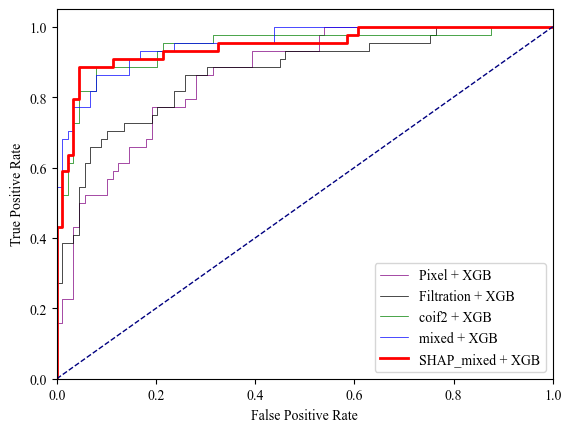

In [70]:
# 使用matplotlib绘制ROC曲线
from sklearn.metrics import roc_curve
plt.figure()
lw=0.5
fpr, tpr, thresholds = roc_curve(y_test, pre['pixel_xgboost_pre'][:,1])
plt.plot(fpr, tpr,lw=lw,color='purple', label='Pixel + XGB')
fpr, tpr, thresholds = roc_curve(y_test,pre['orige_p_xgboost_pre'][:,1])
plt.plot(fpr, tpr,lw=lw, color='black' ,label='Filtration + XGB')
fpr, tpr, thresholds = roc_curve(y_test,pre['haar_xgboost_pre'][:,1])
plt.plot(fpr, tpr, lw=lw, color='green',label='coif2 + XGB')
fpr, tpr, thresholds = roc_curve(y_test,pre['8W2O_xgboost_pre'][:,1])
plt.plot(fpr, tpr,lw=lw, color='blue' ,label='mixed + XGB')
fpr, tpr, thresholds = roc_curve(y_test,pre['8W2Os_xgboost_pre'][:,1])
plt.plot(fpr, tpr,lw=2 , color='red',label='SHAP_mixed + XGB')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Other Figures

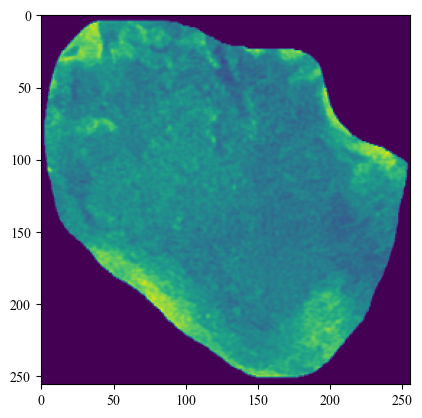

0


In [76]:
# 原图 
toPIL = transforms.ToPILImage()
pic = toPIL(X_test[-4])
plt.imshow(pic)
plt.show()
print(y_test[-4])

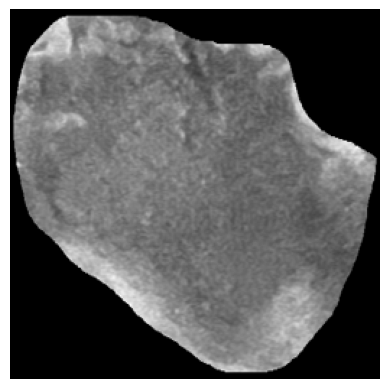

In [78]:
plt.imshow(np.array(X_test[-4]), cmap='gray') 
plt.axis('off')
plt.show()

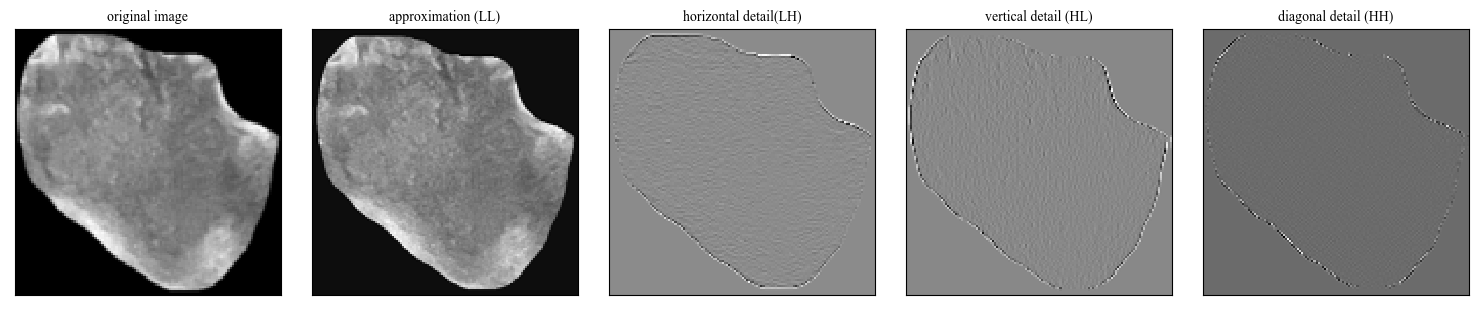

In [81]:
# 小波特征
resize = transforms.Resize((114, 114))
toPIL = transforms.ToPILImage()

titles = ['original image','approximation (LL)','horizontal detail(LH)','vertical detail (HL)','diagonal detail (HH)']
coeffs2 = pywt.dwt2(X_test[-4], 'coif1')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(15, 3))
for i, a in enumerate([np.array(resize(toPIL(X_test[-4]))),LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()


In [82]:
# 热图函数 以及 比例二值化管道 （越小点越多）

import plotly.graph_objects as gobj
def plot_heatmap(data, x=None, y=None, colorscale="greys", origin="upper",
                 title=None, plotly_params=None):
    autorange = True if origin == "lower" else "reversed"
    layout = {
        "xaxis": {"scaleanchor": "y", "constrain": "domain", "visible": False},
        "yaxis": {"autorange": autorange, "constrain": "domain", "visible": False},
        "plot_bgcolor": "white",
        "title": title
        }

    fig = gobj.Figure(layout=layout)
    fig.add_trace(gobj.Heatmap(z=data * 1, x=x, y=y, colorscale=colorscale))


    if plotly_params:
        fig.update_traces(plotly_params.get("trace", None))
        fig.update_layout(plotly_params.get("layout", None))
    fig.update_traces (showscale=False)
    
    return fig

class Binarizer_p(BaseEstimator, TransformerMixin):
    def __init__(self, percentile):
        self.percentile = percentile
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        threshold = torch.kthvalue(X[X > 0],int(X[X > 0].numel() *self.percentile+1))[0]
        return (X > threshold).float().numpy()



In [95]:
# 二值化
from gtda.images import Binarizer
gray=torch.tensor(LL).reshape(1,130,130)
binarizer = Binarizer_p(percentile=0.4)
gray_binarized = binarizer.fit_transform(gray)

plot_heatmap(gray_binarized[0])

In [131]:

import numpy as np
import matplotlib.pyplot as plt
from gtda.images import Binarizer, HeightFiltration
from gtda.diagrams import PersistenceLandscape, BettiCurve, HeatKernel
from gtda.plotting import plot_diagram, plot_heatmap


In [96]:
# 高度过滤器
plot_heatmap(HeightFiltration(direction=np.array([0, 1]), n_jobs=-1).fit_transform(gray_binarized)[0], colorscale="jet")

In [167]:
# 高度过滤器 持久图
diagrams = cubical_persistence.fit_transform(HeightFiltration(direction=np.array([0, 1]), n_jobs=-1).fit_transform(gray_binarized))
cubical_persistence.plot(diagrams)

In [160]:
# 计算持久同源性
diagrams = cubical_persistence.fit_transform(HeightFiltration(direction=np.array([0, 1]), n_jobs=-1).fit_transform(gray_binarized))

In [165]:
cubical_persistence.plot(diagrams)

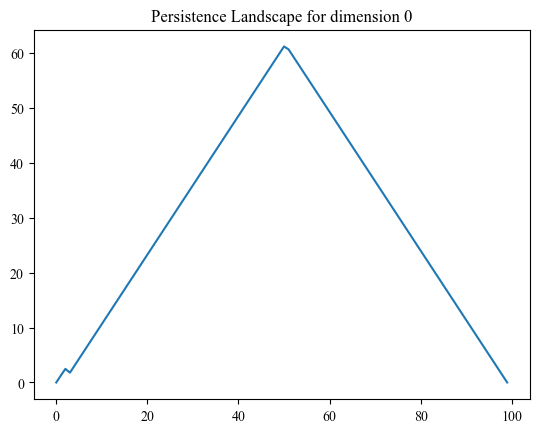

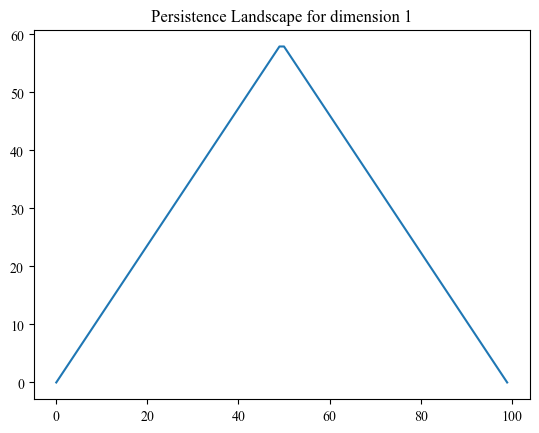

In [162]:
# 计算持久性景观
landscape = PersistenceLandscape()
landscapes = landscape.fit_transform(diagrams)

# 绘制持久性景观
for dim in range(len(landscapes[0])):
    plt.plot(landscapes[0][dim].T)
    plt.title(f'Persistence Landscape for dimension {dim}')
    plt.show()


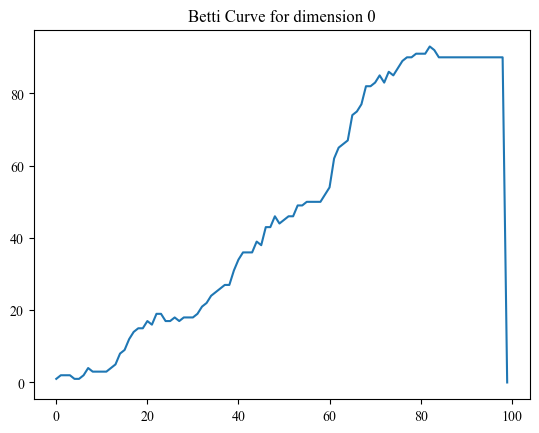

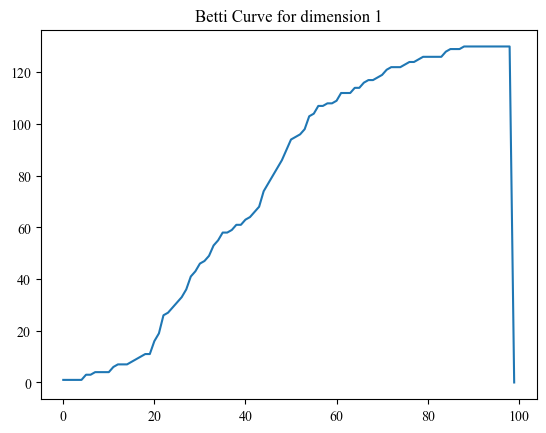

In [163]:
# 计算Betti曲线
betti_curve = BettiCurve()
betti_curves = betti_curve.fit_transform(diagrams)

# 绘制Betti曲线
for dim in range(len(betti_curves[0])):
    plt.plot(betti_curves[0][dim])
    plt.title(f'Betti Curve for dimension {dim}')
    plt.show()


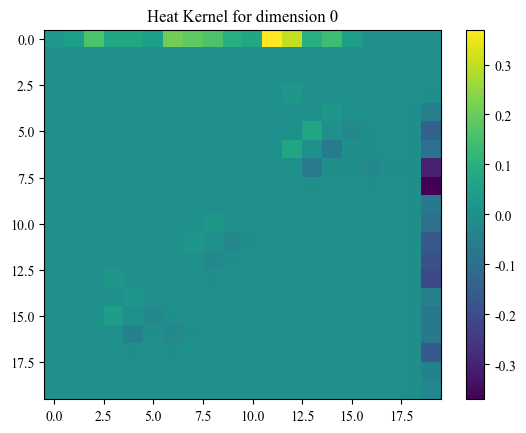

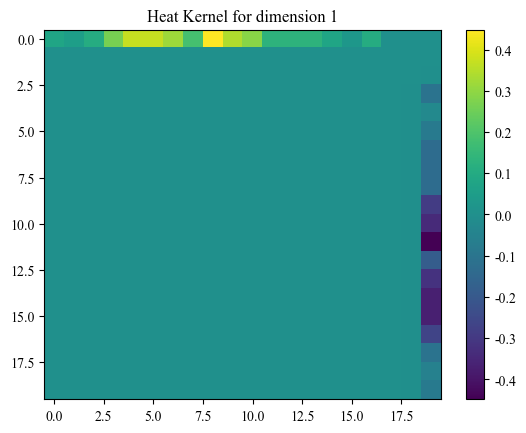

In [164]:
# 计算热核
heat_kernel = HeatKernel(sigma=1.0, n_bins=20)
heat_kernels = heat_kernel.fit_transform(diagrams)

# 绘制热核
for dim in range(len(heat_kernels[0])):
    plt.imshow(heat_kernels[0][dim], aspect='auto')
    plt.title(f'Heat Kernel for dimension {dim}')
    plt.colorbar()
    plt.show()


In [97]:
# 径向过滤器
radial_filtration = RadialFiltration(center=np.array([20, 6]))
plot_heatmap(radial_filtration.fit_transform(gray_binarized)[0], colorscale="jet")

In [98]:
# 密度过滤器
plot_heatmap(DensityFiltration().fit_transform(gray_binarized)[0], colorscale="jet")

In [114]:
# 密度过滤器 持久图
cubical_persistence.plot(cubical_persistence.fit_transform(DensityFiltration().fit_transform(gray_binarized)))

In [99]:
# 侵蚀过滤器
plot_heatmap(ErosionFiltration().fit_transform(gray_binarized)[0], colorscale="jet")

In [113]:
# 侵蚀过滤器 持久图
cubical_persistence.plot(cubical_persistence.fit_transform(ErosionFiltration().fit_transform(gray_binarized)))

In [118]:
# 膨胀过滤器
plot_heatmap(DilationFiltration().fit_transform(gray_binarized)[0], colorscale="jet")

In [119]:
# 保存持久性图
A = radial_filtration.fit_transform(gray_binarized)
B = ErosionFiltration().fit_transform(gray_binarized)
C = DilationFiltration().fit_transform(gray_binarized)
cubical_persistence = CubicalPersistence(n_jobs=-1)

In [ ]:
fig = cubical_persistence.plot(diagrams)

# 使用 plotly 的保存功能保存图像
fig.write_image("persistence_diagram.png")

In [168]:
cubical_persistence.plot(cubical_persistence.fit_transform(A))

In [121]:
cubical_persistence.plot(cubical_persistence.fit_transform(B))

In [122]:
cubical_persistence.plot(cubical_persistence.fit_transform(C))

In [123]:
gray=torch.tensor(LL).reshape(1,130,130)
binarizer = Binarizer_p(percentile=0.4)
gray_binarized = binarizer.fit_transform(gray)

Binarizer(threshold=0.4).plot(gray_binarized)

In [126]:
# 绘图
# 原图
toPIL = transforms.ToPILImage()
pic = toPIL(X_test[1])
# 二值化
gray = torch.tensor(LL).reshape(1,130,130)
binarizer = Binarizer_p(percentile=0.4)
gray_binarized = binarizer.fit_transform(gray)
# 过滤器
A = radial_filtration.fit_transform(gray_binarized)
B = ErosionFiltration().fit_transform(gray_binarized)
C = DilationFiltration().fit_transform(gray_binarized)
# 持久性图
persistence_A = Image.open('persistence_A.png')
persistence_B = Image.open('persistence_B.png')
persistence_C = Image.open('persistence_C.png')
# 创建一个包含四个子图的大图
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
# 清除其他子图的内容
for i in range(5):
    for j in range(5):
        axs[i, j].axis('off')
# 分别放入指定的子图中
axs[2, 0].imshow(pic)
axs[2, 0].set_title("原图")

axs[1, 1].imshow(LL, cmap='gray')
axs[1, 1].set_title("小波特征LL")
axs[3, 1].imshow(LH, cmap='gray')
axs[3, 1].set_title("小波特征LH")
axs[4, 1].set_title("…………")

axs[1, 2].imshow(gray_binarized[0], cmap='gray')
axs[1, 2].set_title("二值化")

axs[0, 3].imshow(A[0], cmap='jet')
axs[0, 3].set_title("radial_filtration")
axs[1, 3].imshow(B[0], cmap='jet')
axs[1, 3].set_title("ErosionFiltration")
axs[2, 3].imshow(C[0], cmap='jet')
axs[2, 3].set_title("DilationFiltration")
axs[3, 3].set_title("…………")

axs[0, 4].imshow(persistence_A, cmap='jet')
axs[0, 4].set_title("persistence diagram")
axs[1, 4].imshow(persistence_B, cmap='jet')
axs[1, 4].set_title("persistence diagram")
axs[2, 4].imshow(persistence_C, cmap='jet')
axs[2, 4].set_title("persistence diagram")
axs[3, 4].set_title("…………")

# 调整子图之间的间距
plt.tight_layout()
# 显示大图
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'persistence_A.png'